# Atmospheric processes: from cloud to global scales
# Exercise on radar, microphysics and mountain meteorology

## Introduction 

In this exercise, you will analyze numerical model simulations and observational data corresponding to snowfall events at Jungfraujoch in January 2014. 

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from mch_parameters import params
import matplotlib.colors as colors
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m')
plt.rcParams['font.size']=14
import wrf



Below is a description of the numerical model that was used (adapted from Georgakaki et al., 2022, and from https://www2.mmm.ucar.edu/wrf/users/wrf_model.html)

*The simulations are computed with the Weather and Research Forecast (WRF) model, version 4.0, with augmented cloud microphysics to include the effects of additional secondary ice production (SIP) mechanisms (Sotiropoulou et al., 2021).\
The equation set in WRF is fully compressible, Eulerian and nonhydrostatic. It is conservative for scalar variables.\
The model uses terrain-following, hybrid sigma-pressure vertical coordinate with the top of the model being a constant pressure surface; a refined vertical grid spacing was used for these simulations following Vignon et al. 2021.\
The model has been run with three two-way nested domains (Fig. 1), with a respective horizontal resolution of 12, 3, and 1 km. The Lambert conformal projection is applied to all three domains. Arakawa-C grid staggering is used for the horizontal grid.\
The time integration scheme in the model uses the third-order Runge-Kutta scheme, and the spatial discretization employs 2nd to 6th order schemes.\
Regarding the physics options chosen to run the simulations, the Rapid Radiative Transfer Model for General Circulation Models (RRTMG) radiation scheme is applied to parameterize both the short-wave and long-wave radiative transfer.\
The vertical turbulent mixing is treated with the Mellor–Yamada–Janjić (MYJ; Janjić, 2001) 1.5 order scheme. The Kain–Fritsch cumulus parameterization has been activated only in the outermost domain, as the resolution of the two nested domains is sufficient to reasonably resolve cumulus-type clouds at grid scale.\
The fifth generation of the European Centre for Medium-Range Weather Forecasts (ECMWF) atmospheric reanalyses dataset (ERA5; Hersbach et al., 2020) is used to initialize the model and provide the lateral forcing at the edge of the 12 km resolution domain every 6h.*

> **Question 1** In the model description, identify keywords that were covered in class, and explain their meaning. 

> **Question 2** Discuss the choice of the projection.

> **Question 3** How do you understand the sentence "The Kain–Fritsch cumulus parameterization (...) at grid scale"? 
(**NOTE TO DO** Here the idea is to let the students reflect on the concept of parameterization - depending on the grid size, some processes need to be parameterized vs can be fully resolved) 

We first assess the ability of the model to reproduce observed standard atmospheric variables: Temperature, relative humidity, wind speed and wind direction.
This is a first safety check to ensure that the simulations are able to capture accurately the atmospheric conditions on the days of the events.

For this, we compare modeled fields to measurements from an automatic weather station of MeteoSwiss located at Jungfraujoch.


In [3]:
ctrl_nw = Dataset('Data/WRF/CNTRL_NW.nc')
ctrl_se = Dataset('Data/WRF/CNTRL_SE.nc')
t0_nw = datetime.datetime.timestamp(datetime.datetime(year=2014, month=1, day=25, hour=0, tzinfo = datetime.timezone.utc))
t0_se = datetime.datetime.timestamp(datetime.datetime(year=2014, month=1, day=29, hour=0, tzinfo = datetime.timezone.utc))
dt_nw = [datetime.datetime.fromtimestamp(tt*60+t0_nw, tz=datetime.timezone.utc) for tt in ctrl_nw.variables['XTIME'][:]]
dt_se = [datetime.datetime.fromtimestamp(tt*60+t0_se, tz=datetime.timezone.utc) for tt in ctrl_se.variables['XTIME'][:]]
i_start = 50

In [4]:
mch_obs = pd.read_fwf('Data/observations/MCH_JFJ_data_10min.txt')
dt_mch = pd.to_datetime(mch_obs['time'],format='%Y%m%d%H%M')
for var in mch_obs.columns[2:]:
    params[var]['data'] = mch_obs[var].replace('-','nan').to_numpy(dtype='f')
            

In [5]:
ctrl_temp_nw = wrf.getvar(ctrl_nw,'T2',timeidx=wrf.ALL_TIMES)-273.15
ctrl_temp_se = wrf.getvar(ctrl_se,'T2',timeidx=wrf.ALL_TIMES)-273.15
ctrl_rh_nw = wrf.getvar(ctrl_nw,'rh2',timeidx=wrf.ALL_TIMES)
ctrl_rh_se = wrf.getvar(ctrl_se,'rh2',timeidx=wrf.ALL_TIMES)

ctrl_wspd_nw = np.sqrt(ctrl_nw.variables['U10'][:,0,0]**2+ctrl_nw.variables['V10'][:,0,0]**2)
ctrl_wspd_se = np.sqrt(ctrl_se.variables['U10'][:,0,0]**2+ctrl_se.variables['V10'][:,0,0]**2)
ctrl_wdir_nw = np.arctan(ctrl_nw.variables['V10'][:,0,0]/ctrl_nw.variables['U10'][:,0,0])*180/np.pi+360
ctrl_wdir_se = np.arctan(ctrl_se.variables['V10'][:,0,0]/ctrl_se.variables['U10'][:,0,0])*180/np.pi+180

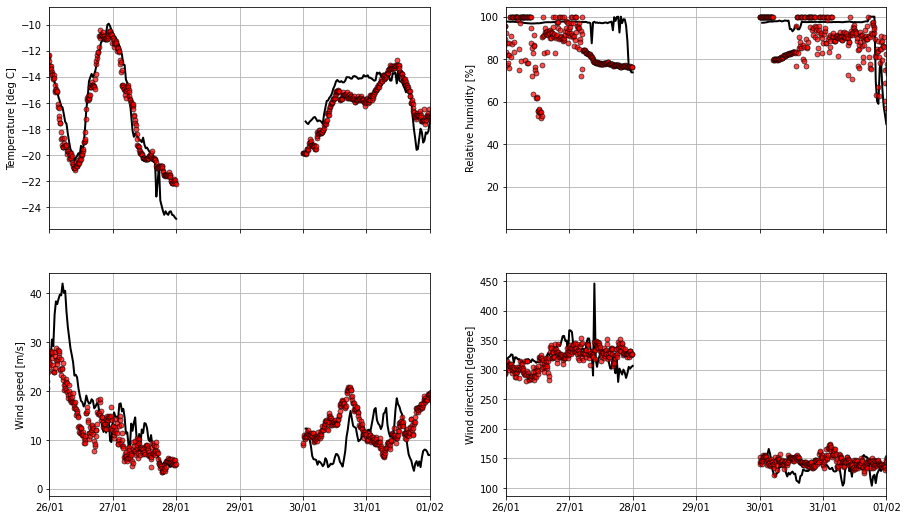

In [6]:
mch_vars = ['tre200s0', 'ure200s0','fkl010z0', 'dkl010z0']
plt.rcParams['font.size']=14
fig, axs = plt.subplots(2,2,figsize=(15,9), sharex=True)

axs[0,0].plot(dt_nw, ctrl_temp_nw,'k',lw=2)
axs[0,0].plot(dt_se[i_start:], ctrl_temp_se[i_start:],'k',lw=2)
axs[0,1].plot(dt_nw,ctrl_rh_nw,'k',lw=2)
axs[0,1].plot(dt_se[i_start:],ctrl_rh_se[i_start:],'k',lw=2)
axs[1,0].plot(dt_nw,ctrl_wspd_nw,'k',lw=2)
axs[1,0].plot(dt_se[i_start:],ctrl_wspd_se[i_start:],'k',lw=2)
axs[1,1].plot(dt_nw,ctrl_wdir_nw,'k',lw=2)
axs[1,1].plot(dt_se[i_start:],ctrl_wdir_se[i_start:],'k',lw=2)

for i_ax, ax in enumerate(axs.flatten()):
    ax.plot(dt_mch,params[mch_vars[i_ax]]['data'],linestyle='', marker='o',markersize=5, color='red',markeredgecolor='k',mew=0.75,alpha=.7)
    ax.set_ylabel(params[mch_vars[i_ax]]['name']+' ['+params[mch_vars[i_ax]]['units']+']')
    ax.grid(zorder=100)
    ax.set_xlim(datetime.datetime(2014,1,26), datetime.datetime(2014,2,1))
    ax.xaxis.set_major_formatter(myFmt)
axs[1,0].set_xlabel('Time [UTC]')
axs[1,1].set_xlabel('Time [UTC]')


> **Question 4** What do you think of the agreement between the model outputs and the observations, for each of the variables plotted above?

We then investigate the model results in terms of ice crystal number concentration (ICNC), ice water content (IWC) and liquid water content (LWC).

> **Question 5** Why are these variables interesting? Think of their relevance for both climate and weather research.

In [7]:
icnc_obs_nw = pd.read_csv('Data/observations/ICNC_obs_NW.csv',sep=';')
iwc_obs_nw = pd.read_csv('Data/observations/IWC_obs_NW.csv',sep=';')
lwc_obs_nw = pd.read_csv('Data/observations/LWC_obs_NW.csv',sep=';')
icnc_obs_se = pd.read_csv('Data/observations/ICNC_obs_SE.csv',sep=';')
iwc_obs_se = pd.read_csv('Data/observations/IWC_obs_SE.csv',sep=';')
lwc_obs_se = pd.read_csv('Data/observations/LWC_obs_SE.csv',sep=';')

vars_icnc = ['QNGRAUPEL', 'QNICE', 'QNSNOW']
vars_iwc = ['QGRAUP', 'QICE', 'QSNOW']
vars_lwc = ['QCLOUD', 'QRAIN']

rho_air_nw = ctrl_nw.variables['PSFC'][:,0,0] / ctrl_nw.variables['T2'][:,0,0] / 287
rho_air_se = ctrl_se.variables['PSFC'][:,0,0] / ctrl_se.variables['T2'][:,0,0] / 287

ICNC_NW = sum([ctrl_nw.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_nw*1e-3
ICNC_SE = sum([ctrl_se.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_se*1e-3
IWC_NW = sum([ctrl_nw.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_nw*1e3
IWC_SE = sum([ctrl_se.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_se*1e3
LWC_NW = sum([ctrl_nw.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_nw*1e3
LWC_SE = sum([ctrl_se.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_se*1e3


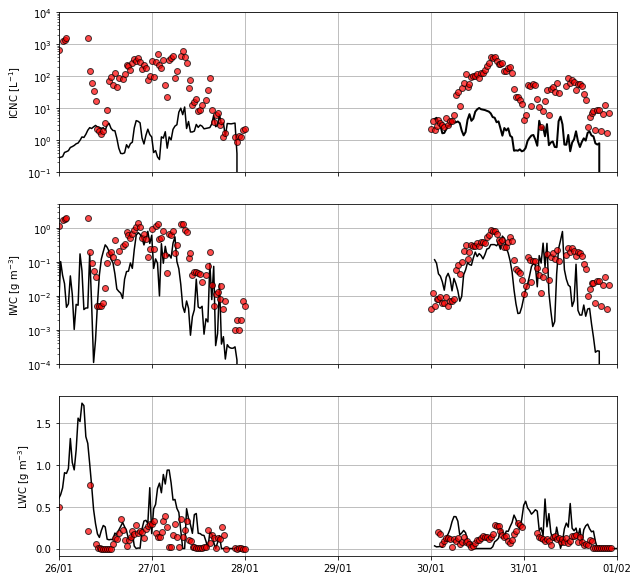

In [8]:
fig, axs = plt.subplots(3,figsize=(10,10),sharex=True)
axs[0].plot(dt_nw, ICNC_NW,'k')
axs[0].plot(dt_se[i_start:], ICNC_SE[i_start:],'k', lw=2)
axs[0].plot(pd.to_datetime(icnc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_nw['ICNC(L-1)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[0].plot(pd.to_datetime(icnc_obs_se['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_se['ICNC(L-1)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 1e4)
axs[0].set_ylabel('ICNC [L$^{-1}$]')

axs[1].plot(dt_nw,IWC_NW,'k')
axs[1].plot(dt_se[i_start:],IWC_SE[i_start:],'k')
axs[1].plot(pd.to_datetime(iwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_nw['IWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[1].plot(pd.to_datetime(iwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_se['IWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4,5)
axs[1].set_ylabel('IWC [g m$^{-3}$]')

axs[2].plot(dt_nw,LWC_NW,'k')
axs[2].plot(dt_se[i_start:], LWC_SE[i_start:],'k')
axs[2].plot(pd.to_datetime(lwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_nw['LWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[2].plot(pd.to_datetime(lwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_se['LWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[2].set_ylabel('LWC [g m$^{-3}$]')
axs[2].set_xlabel('Time [UTC]')

for ax in axs.flatten():
    ax.set_xlim(datetime.datetime(2014,1,26), datetime.datetime(2014,2,1))
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()



>**Question 6** What do you think of the agreement between the model outputs and the observations, for each of the variables plotted above.

>**Question 6bis** Compare the model/obs agreement for ICNC and IWC. What does it reflect about the particle size distribution (PSD)?

In the next questions, we will explore the sensitivity of the model outputs to changes in the microphysical parameterizations. The sensitivity simulations explore the possible impact of secondary ice production (SIP) and blowing snow processes.

> **Question 7** Recall what secondary ice production refers to.

Different mechanisms for secondary ice production exist (Korolev et al., 2020). For instance:
- ***Droplet shattering*** occurs when a large supercooled liquid water drop freezes (upon contact with an ice nucleating particle or with an ice crystal) and shatters into several ice fragments. This is due to the differential pressure resultng from the formation of an outer shell on the drop.
- ***Collisional breakup*** occurs when collisions between ice crystals produce ice fragments. The collisions are typically facilitated in regions with atmospheric turbulence, or when ice particles have different settling velocities. The presence of rimed particles is an important ingredient as these particles, with their higher mass and fall speed, are more likely to cause efficient breakup during high-kinetic-energy collisions with other ice particles.

In addition, another process that can take place in mountainous regions is blowing snow, i.e., snow particles being lifted from the surface by wind. 


The simulations that were conducted are the following:
- `CNTRL`: Control simulation, plotted in the previous cell.
- `BIPS_10`: Includes blowing snow processes, modeled with a constant source of ice crystals at the lowest model level ($10 L^{-1}$). The ice particles injected in the atmosphere from the surface are then redistributed through advection, sublimation and sedimentation.
- `BIPS_100`: Same but with a higher injection of blowing snow particles ($100 L^{-1}$).
- `DS_PHILL`: Includes SIP through droplet shattering, simulated with the parameterization of Phillips et al., 2018.
- `DS_SULL`: Includes SIP through droplet shattering, simulated with a different parameterization (Sullivan et al., 2018)
- `BR_PHILL`: Includes SIP through collisional breakup, simulated with the parameterization of Phillips et al., 2017.
- `BR_TAKAH`: Includes SIP through collisional breakup, simulated with the parameterization of Takahashi et al., 1995.
- `BR_TAKAHrim`: Includes SIP through collisional breakup, simulated with the parameterization of Takahashi et al., 1995, activated only after collisions between rimed particles.
- `BIPS100_PHILL`: Includes SIP through collisional breakup (Phillips et al., 2017) and blowing snow ($100 L^{-1}$)


In the cell below, define the list of simulations that you want to display (you can plot them all at once but this may be more difficult to read) inside the variable `SIM_LIST`.\
-> In the first figure, we display the time series of model outputs (for the selected simulation settings) and observations.\
-> In the second figure, we plot the distributions of each variable for observations and for the model outputs. NB to plot the simulated LWC distributions, we remove the beginning of the timeseries where observations are missing, as this could bias the comparison.

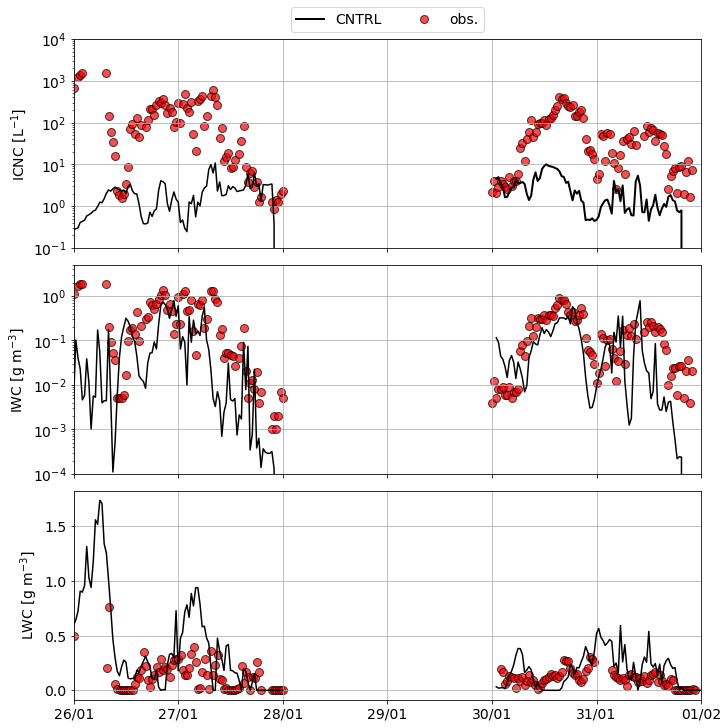

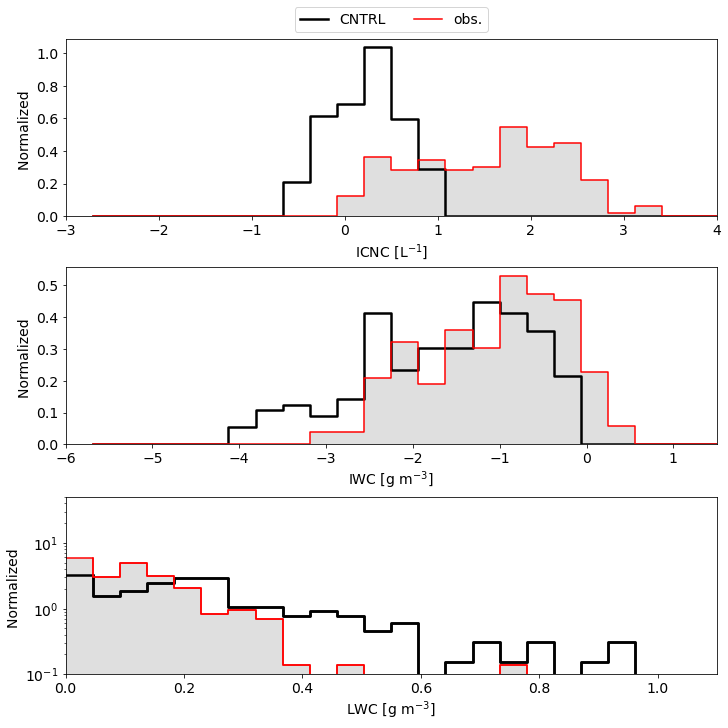

In [9]:
SIM_LIST = ['CNTRL', 
            # 'BIPS_10', 
            # 'BIPS_100', 
            # 'DS_PHILL', 
            # 'DS_SULL', 
            # 'BR_PHILL', 
            # 'BR_TAKAH', 
            # 'BR_TAKAHrim', 
            # 'BIPS100_PHILL'
            ]

####################################################

color_dict = {'CNTRL':'k', 'BIPS_10':'deepskyblue', 'BIPS_100': 'royalblue', 'DS_PHILL':'hotpink', 'DS_SULL':'violet', 'BR_PHILL':'green', 'BR_TAKAH':'turquoise', 'BR_TAKAHrim': 'lightgreen', 'BIPS100_PHILL':'orange'}
if len(SIM_LIST)<=4:
    ncol = len(SIM_LIST)+1
else:
    ncol = int((len(SIM_LIST)+2)/2)

i_start_nw = 48
i_start_se = 50
i_start_nw_lwc = 68 # because we have a lot of NaN in the obs

plt.rcParams['font.size']=14

fig, axs = plt.subplots(3,figsize=(10,10),sharex=True,constrained_layout = True)
for sim in SIM_LIST:
    nc_tp_nw = Dataset(f'Data/WRF/{sim}_NW.nc')
    nc_tp_se = Dataset(f'Data/WRF/{sim}_SE.nc')

    rho_air_nw = nc_tp_nw.variables['PSFC'][:,0,0] / ctrl_nw.variables['T2'][:,0,0] / 287
    rho_air_se = nc_tp_se.variables['PSFC'][:,0,0] / ctrl_se.variables['T2'][:,0,0] / 287

    ICNC_NW = sum([nc_tp_nw.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_nw*1e-3
    ICNC_SE = sum([nc_tp_se.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_se*1e-3
    IWC_NW = sum([nc_tp_nw.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_nw*1e3
    IWC_SE = sum([nc_tp_se.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_se*1e3
    LWC_NW = sum([nc_tp_nw.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_nw*1e3
    LWC_SE = sum([nc_tp_se.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_se*1e3

    axs[0].plot(dt_nw, ICNC_NW,color_dict[sim])
    axs[0].plot(dt_se[i_start_se:], ICNC_SE[i_start_se:],color_dict[sim], lw=2, label=sim)    

    axs[1].plot(dt_nw,IWC_NW,color_dict[sim])
    axs[1].plot(dt_se[i_start_se:],IWC_SE[i_start_se:],color_dict[sim])
    
    axs[2].plot(dt_nw[48:],LWC_NW[48:],color_dict[sim])
    axs[2].plot(dt_se[i_start_se:], LWC_SE[i_start_se:],color_dict[sim])
    

axs[0].plot(pd.to_datetime(icnc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_nw['ICNC(L-1)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1,label='obs.')
axs[0].plot(pd.to_datetime(icnc_obs_se['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_se['ICNC(L-1)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 1e4)
axs[0].set_ylabel('ICNC [L$^{-1}$]')

axs[1].plot(pd.to_datetime(iwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_nw['IWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[1].plot(pd.to_datetime(iwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_se['IWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4,5)
axs[1].set_ylabel('IWC [g m$^{-3}$]')

axs[2].plot(pd.to_datetime(lwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_nw['LWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[2].plot(pd.to_datetime(lwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_se['LWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[2].set_ylabel('LWC [g m$^{-3}$]')

for ax in axs.flatten():
    ax.set_xlim(datetime.datetime(2014,1,26), datetime.datetime(2014,2,1))
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()
axs[0].legend(ncol=ncol,bbox_to_anchor=(0.5,1),loc='lower center')


#####################

fig, axs = plt.subplots(3,figsize=(10,10),constrained_layout = True)
nbins = 25
bins_icnc = np.linspace(-3.,4,nbins)
bins_iwc = np.linspace(-6,1.5,nbins)
bins_lwc = np.linspace(0.,1.1,nbins)

for sim in SIM_LIST:
    nc_tp_nw = Dataset(f'Data/WRF/{sim}_NW.nc')
    nc_tp_se = Dataset(f'Data/WRF/{sim}_SE.nc')

    rho_air_nw = nc_tp_nw.variables['PSFC'][i_start_nw:,0,0] / ctrl_nw.variables['T2'][i_start_nw:,0,0] / 287
    rho_air_se = nc_tp_se.variables['PSFC'][i_start_se:,0,0] / ctrl_se.variables['T2'][i_start_se:,0,0] / 287

    ICNC_NW = sum([nc_tp_nw.variables[v][i_start_nw:,0,0,0] for v in vars_icnc])*rho_air_nw*1e-3
    ICNC_SE = sum([nc_tp_se.variables[v][i_start_se:,0,0,0] for v in vars_icnc])*rho_air_se*1e-3
    IWC_NW = sum([nc_tp_nw.variables[v][i_start_nw:,0,0,0] for v in vars_iwc])*rho_air_nw*1e3
    IWC_SE = sum([nc_tp_se.variables[v][i_start_se:,0,0,0] for v in vars_iwc])*rho_air_se*1e3
    LWC_NW = sum([nc_tp_nw.variables[v][i_start_nw_lwc:,0,0,0] for v in vars_lwc])*rho_air_nw[i_start_nw_lwc-i_start_nw:]*1e3
    LWC_SE = sum([nc_tp_se.variables[v][i_start_se:,0,0,0] for v in vars_lwc])*rho_air_se*1e3

    nnw,bnw = np.histogram(np.log10(np.concatenate((ICNC_NW[ICNC_NW>0], ICNC_SE[ICNC_SE>0]))), bins = bins_icnc,density = True)
    axs[0].step( bnw[1:], nnw, linewidth=2.5, color = color_dict[sim], label=sim)
    nnw,bnw = np.histogram(np.log10(np.concatenate((IWC_NW[IWC_NW>0], IWC_SE[IWC_SE>0]))), bins = bins_iwc,density = True)
    axs[1].step( bnw[1:], nnw, linewidth=2.5, color = color_dict[sim], label=sim)
    nnw,bnw = np.histogram((np.concatenate((LWC_NW[LWC_NW>0], LWC_SE[LWC_SE>0]))), bins = bins_lwc,density = True)
    axs[2].step( bnw[1:], nnw, linewidth=2.5, color = color_dict[sim], label=sim)
    axs[2].step( bnw[:-1], nnw, linewidth=2.5, color = color_dict[sim], label=sim, where='post')
    
nobs,bobs = np.histogram(np.log10(np.concatenate((icnc_obs_nw['ICNC(L-1)'], icnc_obs_se['ICNC(L-1)']))), bins = bins_icnc, density = True)
axs[0].step(bobs[1:], nobs, color='r', label = 'obs.')
axs[0].hist(np.log10(np.concatenate((icnc_obs_nw['ICNC(L-1)'], icnc_obs_se['ICNC(L-1)']))), bins = bins_icnc, density = True, color='gray',alpha=.25,zorder=-1)
axs[0].set_xlim(bobs[0],bobs[-1])

nobs,bobs = np.histogram(np.log10(np.concatenate((iwc_obs_nw['IWC(gm-3)'], iwc_obs_se['IWC(gm-3)']))), bins = bins_iwc, density = True)
axs[1].step(bobs[1:], nobs, color='r')
axs[1].hist(np.log10(np.concatenate((iwc_obs_nw['IWC(gm-3)'], iwc_obs_se['IWC(gm-3)']))), bins = bins_iwc, density = True, color='gray',alpha=.25,zorder=-1)
axs[1].set_xlim(bobs[0],bobs[-1])

nobs,bobs = np.histogram((np.concatenate((lwc_obs_nw['LWC(gm-3)'], lwc_obs_se['LWC(gm-3)']))), bins = bins_lwc, density = True)
axs[2].step(bobs[1:], nobs, color='r')
axs[2].step(bobs[:-1], nobs, color='r',where='post')
axs[2].hist((np.concatenate((lwc_obs_nw['LWC(gm-3)'], lwc_obs_se['LWC(gm-3)']))), bins = bins_lwc, density = True, color='gray',alpha=.25,zorder=-1)
axs[2].set_xlim(bobs[0],bobs[-1])

axs[0].legend(ncol=ncol,bbox_to_anchor=(0.5,1),loc='lower center')

axs[0].set_xlabel('ICNC [L$^{-1}$]')
axs[1].set_xlabel('IWC [g m$^{-3}$]')
axs[2].set_xlabel('LWC [g m$^{-3}$]')
axs[2].set_yscale('log')
axs[2].set_ylim(.1,50)
axs[2].set_xlabel('Time [UTC]')

for ax in axs.flatten():
    ax.set_ylabel('Normalized ')

> **Question 8** Based on both figures (timeseries and histograms), discuss the results of each sensitivity simulation, for the three variables (ICNC, IWC, LWC).

>**Question 8bis** What set(s) of simulations provides the best match with the observations? What does it reveal about the microphysical process(es) that are likely taking place? 

To get a better understanding of how the "best" simulation differs from the control one, we will now look at model fields aloft, i.e., at the full vertical profiles of certain relevant variables (instead of point values at the surface).

In the next cell, we show the time-height plots of IWC, LWC and ICNC for the control simulation.


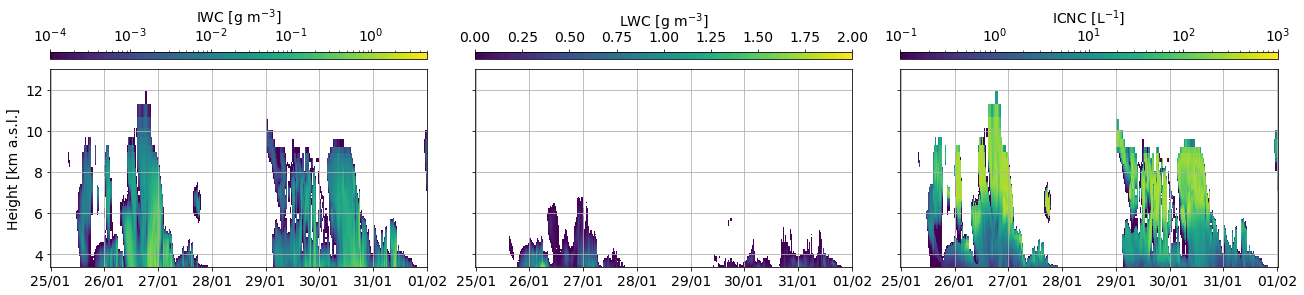

In [18]:
tk_nw = np.array([wrf.getvar(ctrl_nw,'tk',timeidx=i) for i in range(len(ctrl_nw.variables['XTIME']))])
P_nw = (ctrl_nw.variables['P'][:,:,0,0]+ctrl_nw.variables['PB'][:,:,0,0])
rho_profile_nw = P_nw / tk_nw / 287

tk_se = np.array([wrf.getvar(ctrl_se,'tk',timeidx=i) for i in range(len(ctrl_se.variables['XTIME']))])
P_se = (ctrl_se.variables['P'][:,:,0,0]+ctrl_se.variables['PB'][:,:,0,0])
rho_profile_se = P_se / tk_se / 287

ICNC_NW_profile = sum([ctrl_nw.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_nw*1e-3
ICNC_SE_profile = sum([ctrl_se.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_se*1e-3

IWC_NW_profile =  sum([ctrl_nw.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_nw*1e3
IWC_SE_profile = sum([ctrl_se.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_se*1e3

LWC_NW_profile =  sum([ctrl_nw.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_nw*1e3
LWC_SE_profile = sum([ctrl_se.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_se*1e3
LWC_NW_profile[LWC_NW_profile==0] = np.nan
LWC_SE_profile[LWC_SE_profile==0] = np.nan

PHB = ctrl_nw.variables["PHB"][:,:,0,0]
PH = ctrl_nw.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_nw = (ZZASL[:,:-1]+dz).mean(axis=0)

PHB = ctrl_se.variables["PHB"][:,:,0,0]
PH = ctrl_se.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_se = (ZZASL[:,:-1]+dz).mean(axis=0)


fig, axs = plt.subplots(1,3,figsize=(18,4),sharey=True, constrained_layout = True)
axs[0].pcolormesh(dt_se,ZZASL_se/1e3,IWC_SE_profile.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
im0 = axs[0].pcolormesh(dt_nw,ZZASL_nw/1e3,IWC_NW_profile.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
axs[1].pcolormesh(dt_se,ZZASL_se/1e3,LWC_SE_profile.T,vmin=0,vmax=2)
im1 = axs[1].pcolormesh(dt_nw,ZZASL_nw/1e3,LWC_NW_profile.T,vmin = 0,vmax=2)
axs[2].pcolormesh(dt_se,ZZASL_se/1e3,ICNC_SE_profile.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
im2 = axs[2].pcolormesh(dt_nw,ZZASL_nw/1e3,ICNC_NW_profile.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
plt.colorbar(im0,ax=axs[0],orientation='horizontal', location = 'top',aspect = 50, label = 'IWC [g m$^{-3}$]')
plt.colorbar(im1,ax=axs[1],orientation='horizontal',location='top',aspect = 50, label='LWC [g m$^{-3}$]')
plt.colorbar(im2,ax=axs[2],orientation='horizontal', location = 'top',aspect=50, label = 'ICNC [L$^{-1}$]')
axs[0].set_ylim(3.392,13)
axs[0].set_ylabel('Height [km a.s.l.]')
for ax in axs.flatten():
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()
    ax.set_xlabel('Time [UTC]')

/tmp/ipykernel_24650/743599131.py:7: RuntimeWarning: Mean of empty slice
  axs[1].plot(np.nanmean(LWC_NW_profile,axis=0),ZZASL_nw/1e3)
/tmp/ipykernel_24650/743599131.py:8: RuntimeWarning: Mean of empty slice
  axs[1].plot(np.nanmean(LWC_SE_profile,axis=0),ZZASL_se/1e3)


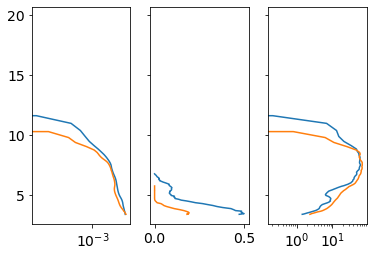

In [11]:
# TO DO DO WE WANT THESE PLOTS?
fig, axs = plt.subplots(1,3,sharey= True)
axs[0].plot(IWC_NW_profile.mean(axis=0),ZZASL_nw/1e3)
axs[0].plot(IWC_SE_profile.mean(axis=0),ZZASL_se/1e3)
axs[0].set_xscale('log')

axs[1].plot(np.nanmean(LWC_NW_profile,axis=0),ZZASL_nw/1e3)
axs[1].plot(np.nanmean(LWC_SE_profile,axis=0),ZZASL_se/1e3)

axs[2].plot(np.mean(ICNC_NW_profile,axis=0), ZZASL_nw/1e3)
axs[2].plot(np.mean(ICNC_SE_profile,axis=0), ZZASL_se/1e3)
axs[2].set_xscale('log')


> **Question 9** Focusing on the profiles of IWC and LWC, describe the cloud structure: is the cloud fully glaciated, is it a mixed phase cloud, or is the composition altitude-dependent (i.e., cloud layers with different properties are present)?

> **Question 9bis (*)** What is the name of such a configuration? Recall what happens in such cases. Here, what microphysical process do you think this favors?

> **Question 10** Focus on the profiles of ICNC. What is the general trend in ICNC from the top to bottom of the cloud? What process is likely taking place?

We now plot the same fields but from the simulation that you identified as the one that fitted the observations best (set the `SIM` variable in the cell below).

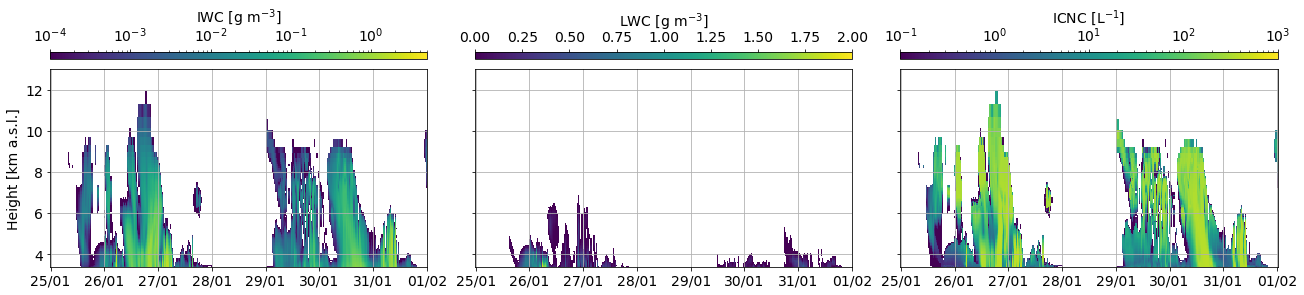

In [19]:
SIM = 'BIPS100_PHILL'

###############################
sim_nw = Dataset(f'Data/WRF/{SIM}_NW.nc')
sim_se = Dataset(f'Data/WRF/{SIM}_SE.nc')
    
tk_nw = np.array([wrf.getvar(sim_nw,'tk',timeidx=i) for i in range(len(ctrl_nw.variables['XTIME']))])
P_nw = (sim_nw.variables['P'][:,:,0,0]+sim_nw.variables['PB'][:,:,0,0])
rho_profile_nw_sim = P_nw / tk_nw / 287

tk_se = np.array([wrf.getvar(sim_se,'tk',timeidx=i) for i in range(len(ctrl_se.variables['XTIME']))])
P_se = (sim_se.variables['P'][:,:,0,0]+ctrl_se.variables['PB'][:,:,0,0])
rho_profile_se_sim = P_se / tk_se / 287

ICNC_NW_profile_sim = sum([sim_nw.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_nw_sim*1e-3
ICNC_SE_profile_sim = sum([sim_se.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_se_sim*1e-3

IWC_NW_profile_sim =  sum([sim_nw.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_nw_sim*1e3
IWC_SE_profile_sim = sum([sim_se.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_se_sim*1e3

LWC_NW_profile_sim =  sum([sim_nw.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_nw_sim*1e3
LWC_SE_profile_sim = sum([sim_se.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_se_sim*1e3
LWC_NW_profile_sim[LWC_NW_profile_sim==0] = np.nan
LWC_SE_profile_sim[LWC_SE_profile_sim==0] = np.nan

PHB = sim_nw.variables["PHB"][:,:,0,0]
PH = sim_nw.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_nw_sim = (ZZASL[:,:-1]+dz).mean(axis=0)

PHB = sim_se.variables["PHB"][:,:,0,0]
PH = sim_se.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_se_sim = (ZZASL[:,:-1]+dz).mean(axis=0)


fig, axs = plt.subplots(1,3,figsize=(18,4),sharey=True, constrained_layout = True)
axs[0].pcolormesh(dt_se,ZZASL_se_sim/1e3,IWC_SE_profile_sim.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
im0 = axs[0].pcolormesh(dt_nw,ZZASL_nw_sim/1e3,IWC_NW_profile_sim.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
axs[1].pcolormesh(dt_se,ZZASL_se_sim/1e3,LWC_SE_profile_sim.T,vmin=0,vmax=2)
im1 = axs[1].pcolormesh(dt_nw,ZZASL_nw_sim/1e3,LWC_NW_profile_sim.T,vmin = 0,vmax=2)
axs[2].pcolormesh(dt_se,ZZASL_se_sim/1e3,ICNC_SE_profile_sim.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
im2 = axs[2].pcolormesh(dt_nw,ZZASL_nw_sim/1e3,ICNC_NW_profile_sim.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
plt.colorbar(im0,ax=axs[0],orientation='horizontal', location = 'top',aspect = 50, label = 'IWC [g m$^{-3}$]')
plt.colorbar(im1,ax=axs[1],orientation='horizontal',location='top',aspect = 50, label='LWC [g m$^{-3}$]')
plt.colorbar(im2,ax=axs[2],orientation='horizontal', location = 'top',aspect=50, label = 'ICNC [L$^{-1}$]')
axs[0].set_ylim(3.392,13)
axs[0].set_ylabel('Height [km a.s.l.]')
for ax in axs.flatten():
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()

>**Question 11** Describe and propose interpretations for the differences between these time-height plots and the ones from the control simulations.

In the cell below, we plot the average profiles of different model variables for the control simulation and the one you selected; to make the plot more readable we only show the first part of the event (25 to 28/01, northwestern flow):
- DNI_BR: The left plot shows the loss/gain in the number of ice crystals due to SIP through collisional breakup.
- DNI_AGG: The middle plot shows the loss/gain in the number of ice crystals due to aggregation.
- ICNC: The right plot shows the mean profile of ICNC.

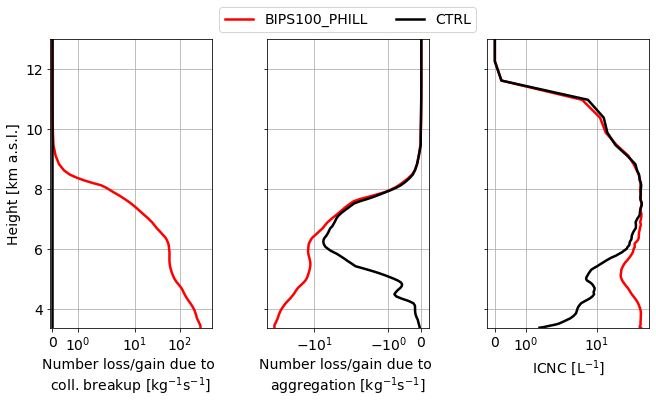

In [54]:
fig,axs = plt.subplots(1,3,figsize=(9,5.5),sharey=True,constrained_layout = True)
axs[0].plot(sim_nw.variables['DNI_BR'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'r',lw=2.5)
axs[0].plot(ctrl_nw.variables['DNI_BR'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'k',lw=2.5)
axs[1].plot(sim_nw.variables['DNI_AGG'][:,:,0,0].mean(axis=0)+sim_nw.variables['DNS_AGG'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'r', lw=2.5,label=SIM)
axs[1].plot(ctrl_nw.variables['DNI_AGG'][:,:,0,0].mean(axis=0)+ctrl_nw.variables['DNS_AGG'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'k',lw=2.5, label='CTRL')
axs[2].plot(ICNC_NW_profile_sim.mean(axis=0), ZZASL_nw_sim/1e3, 'r', lw=2.5)
axs[2].plot(ICNC_NW_profile.mean(axis=0), ZZASL_nw/1e3, 'k', lw=2.5)
axs[0].set_ylim(3.368,13)
axs[0].set_ylabel('Height [km a.s.l.]')
axs[0].set_xlabel('Number loss/gain due to \ncoll. breakup [kg$^{-1}$s$^{-1}$]')
axs[1].set_xlabel('Number loss/gain due to \naggregation [kg$^{-1}$s$^{-1}$]')
axs[0].set_xscale('symlog')
axs[0].set_xlim(-0.1,5e2)
axs[1].set_xscale('symlog')
axs[2].set_xscale('symlog')
axs[2].set_xlabel('ICNC [L$^{-1}$]')
for ax in axs.flatten():
    ax.grid()
axs[1].legend(ncol=2,bbox_to_anchor = (0.5,1), loc='lower center')

> **Question 12** Describe the different profiles. Explain the cofluctuations between the different variables.